In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import seaborn as sns

In [2]:
!pip install imutils

In [3]:
from imutils import paths

In [4]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/Skripsi/data")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

507 images (596.23MB)


In [5]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [6]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(507, 224, 224, 3)


In [7]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 3 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. boulder
2. branching
3. table


In [8]:
def VGG19_model(learning_rate, input_shape,class_number):
    baseModel = VGG19(weights='imagenet',include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [9]:
bs = 8
lr = 0.001
size = (224, 224)
shape = (224,224, 3)
epochs = 20
class_number = 3

In [10]:
model = VGG19_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

In [12]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [13]:
print("[INFO] training ...")
H = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,	validation_data=(testX, testY),	validation_steps=len(testX) // bs,	epochs=epochs)

[INFO] training ...
Epoch 1/20
50/50 [==============================] - 27s 409ms/step - loss: 1.1726 - accuracy: 0.4685 - val_loss: 1.0023 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 8s 140ms/step - loss: 0.9703 - accuracy: 0.5164 - val_loss: 0.8817 - val_accuracy: 0.5000
Epoch 3/20
50/50 [==============================] - 8s 160ms/step - loss: 0.9010 - accuracy: 0.5239 - val_loss: 1.1726 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 6s 122ms/step - loss: 0.8923 - accuracy: 0.5642 - val_loss: 1.0524 - val_accuracy: 0.5098
Epoch 5/20
50/50 [==============================] - 7s 143ms/step - loss: 0.8082 - accuracy: 0.6171 - val_loss: 0.6889 - val_accuracy: 0.7157
Epoch 6/20
50/50 [==============================] - 6s 121ms/step - loss: 0.5897 - accuracy: 0.7758 - val_loss: 0.6527 - val_accuracy: 0.7157
Epoch 7/20
50/50 [==============================] - 8s 154ms/step - loss: 0.7698 - accuracy: 0.7406 - val_loss: 0.7001 - val_ac

In [14]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=bs)
y_predict =predIdxs
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
13/13 [==============================] - 2s 159ms/step
              precision    recall  f1-score   support

     boulder       0.00      0.00      0.00        39
   branching       0.50      1.00      0.67        51
       table       0.00      0.00      0.00        12

    accuracy                           0.50       102
   macro avg       0.17      0.33      0.22       102
weighted avg       0.25      0.50      0.33       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


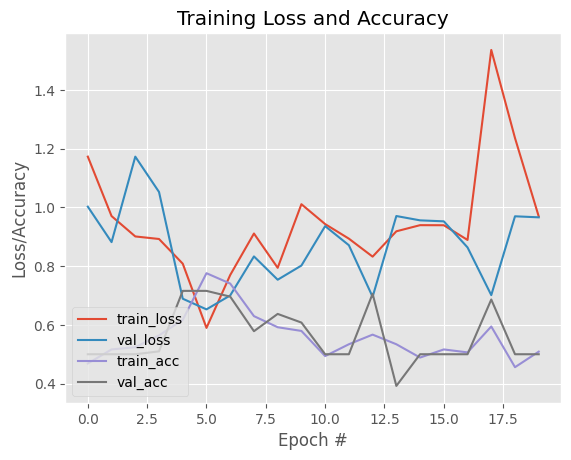

In [15]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

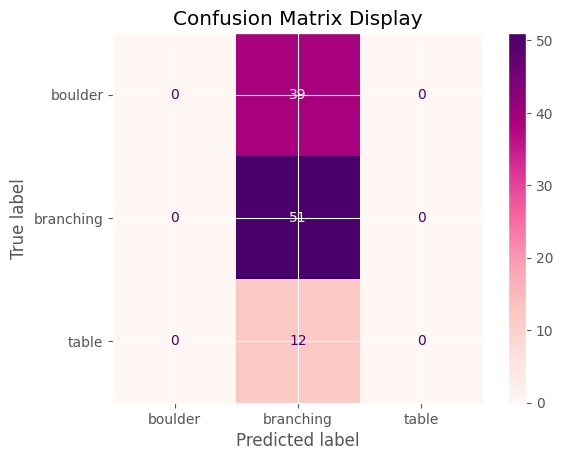

In [16]:
# Pembuatan Confusion Matrix Display
cmd= metrics.confusion_matrix(testY.argmax(axis=1), np.argmax(y_predict, axis=1))
display_label = ['boulder','branching','table']

cm_lr= ConfusionMatrixDisplay(cmd, display_labels = display_label )
cm_lr.plot(cmap=plt.cm.RdPu)
plt.title("Confusion Matrix Display")

plt.show()

In [17]:
model.save('/content/drive/MyDrive/Skripsi/model/VGG19_model_tipe_2.h5')